# 🌊 Wave and Tide Analysis for Coastal Runup

Welcome to this practical session on wave and tide analysis!  
In this notebook, we'll learn how to:

1. Load and explore wave and tide data from CSV files.
2. Visualize time series of tides and waves.
3. Estimate coastal runup using a Python package.

🧠 This notebook is designed for Earth Science students with little or no programming experience. Just follow along and read the comments!

## 📂 Accessing Data from Google Drive

In this step, we:

1. **Mount Google Drive** so we can access files stored in your personal Drive.
2. **Set the working directory** to the folder where your data and scripts are located.
3. (Optionally) **Add a folder to the Python path**, so we can import functions directly from downloaded Python files (like the wave runup model we're using).

> 🔁 **Important:**  
> If this is your **first time** running the notebook, you’ll need to **uncomment** the line that starts with `!git clone` to download the wave runup model from GitHub.  
> You only need to do this **once** — after that, the folder will already be in your Drive.

In [1]:
from google.colab import drive
import os
import sys

# Mount Google Drive
drive.mount('/content/drive')
# Set working folder
working_dir = '/content/drive/MyDrive/CoastalHydrodynamicsBREMEN/wave_runup_model'
# Change directory
%cd $working_dir

# (Optional) clone only if not already cloned
#!git clone https://github.com/chrisleaman/py-wave-runup.git

# Add the folder with models.py to the Python path
models_path = os.path.join(working_dir, 'py-wave-runup')
sys.path.append(models_path)

Drive already mounted at /content/drive; to attempt to forcibly remount, call drive.mount("/content/drive", force_remount=True).
/content/drive/MyDrive/CoastalHydrodynamicsBREMEN/wave_runup_model


## 🧰 Importing Libraries

Before we start working with data, we need to **import some Python libraries**.

These libraries give us tools to:
- 📊 **Load and manipulate data** (`pandas`)
- 📈 **Make plots and visualizations** (`matplotlib`, `seaborn`)
- 🎛️ **Create interactive elements** like dropdowns (`ipywidgets`)
- ➕ **Work with numbers and arrays** (`numpy`)
- 🌊 **Calculate wave runup** using models from `py_wave_runup`

By importing them now, we’ll have everything ready to read data, analyze it, and display the results.

In [2]:
import pandas as pd
import matplotlib.pyplot as plt
from matplotlib.cm import get_cmap
import numpy as np
import seaborn as sns
import ipywidgets as widgets
from IPython.display import display
from py_wave_runup import models

## 📄 Loading and Cleaning Wave and Tide Data

In this step, we load two data files in CSV format:

- **Tide_Gauge.csv**: contains water level measurements recorded over time.
- **Wave_buoy.csv**: contains wave conditions like significant wave height (`Hs`) and wave period (`Tmean`).

We use `pandas` to:
1. **Read the data** from CSV files.
2. **Convert date and time columns** into proper datetime format.
3. **Clean the data** by removing any invalid or missing values.
4. **Set the datetime column as the index** so we can align the wave and tide data later.

This step ensures our data is ready for analysis and visualization.

In [17]:
# Set the path to your tide file
tide_file_path = 'Tide_Gauge.csv'
# Set the path to your wave file
wave_file_path = 'Wave_buoy.csv'


# Read the CSV using semicolon as separator
tides_df = pd.read_csv(tide_file_path, sep=';', dtype=str)
# Combine DATE and TIME into a proper datetime column
tides_df['Datetime'] = pd.to_datetime(tides_df['DATE'] + tides_df['TIME'], format='%Y%m%d%H:%M')
# Clean WaterLevel column
tides_df['WaterLevel'] = pd.to_numeric(tides_df['WaterLevel'], errors='coerce')  # invalid entries become NaN
# Drop rows where WaterLevel is NaN
tides_df = tides_df.dropna(subset=['WaterLevel'])
# Set Datetime as the index
tides_df = tides_df.set_index('Datetime')
# Show result
tides_df.head()

,DATE,TIME,WaterLevel
Datetime,,,
1999-09-13 00:00:00,19990913,00:00,0.389
1999-09-13 00:06:00,19990913,00:06,0.381
1999-09-13 00:12:00,19990913,00:12,0.437
1999-09-13 00:18:00,19990913,00:18,0.459
1999-09-13 00:24:00,19990913,00:24,0.484


In [18]:
# Read and parse the wave buoy data
waves_df = pd.read_csv(wave_file_path)
# Convert the Datetime column to datetime format
waves_df['Datetime'] = pd.to_datetime(waves_df['Datetime'], format='%d/%m/%Y %H:%M:%S')
# Set Datetime as index
waves_df = waves_df.set_index('Datetime')
# Convert numeric columns safely
for col in ['Hs', 'Tmean']:
    waves_df[col] = pd.to_numeric(waves_df[col], errors='coerce')
# Show the first few rows
waves_df.head()

,Hs,Hmax,Tpeak,Tmean
Datetime,,,,
1999-09-13 00:00:00,2.02,3.7572,6.80,7.8200
1999-09-13 03:00:00,2.24,4.1664,6.87,7.9005
1999-09-13 06:00:00,2.39,4.4454,13.48,15.5020
1999-09-13 09:00:00,2.49,4.6314,15.00,17.2500
1999-09-13 12:00:00,2.56,4.7616,14.72,16.9280


## 🔗 Merging Wave and Tide Data by Time

Our wave and tide measurements come from different instruments, and their timestamps don’t match exactly.  
To analyze them together, we need to **match each wave measurement to the closest tide measurement in time**.

Here’s what this code does:

1. **Sort both datasets by time** to prepare for merging.
2. **Reset the index** so we can use the datetime columns in the merge.
3. Use `pandas.merge_asof()` to **merge the wave and tide data based on the nearest timestamp**.
4. Calculate the **time difference (in minutes)** between each matched pair, so we can see how close the timestamps are.

The final result is a new dataframe (`waves_tides`) that combines wave and tide measurements, aligned in time as closely as possible.

In [19]:
# Make sure your datetime columns are named consistently
waves_df = waves_df.sort_index()  # assumes 'Datetime' is already the index
tides_df = tides_df.sort_index()  # assumes 'Datetime' is already the index

# Reset index to access datetime columns for merging
waves_df = waves_df.reset_index().rename(columns={'Datetime': 'time'})
tides_df = tides_df.reset_index().rename(columns={'Datetime': 'dates'})

tides_df['WaterLevel'] = tides_df['WaterLevel'].round(1)
waves_df['Hs'] = waves_df['Hs'].round(1)
waves_df['Tmean'] = waves_df['Tmean'].round(1)

# Merge based on nearest datetime
merged_df = pd.merge_asof(
    waves_df,
    tides_df,
    left_on='time',
    right_on='dates',
    direction='nearest'
)

# Calculate time difference in minutes
merged_df['time_diff'] = ((merged_df['time'] - merged_df['dates']).dt.total_seconds() / 60).round(2)

# Final result
waves_tides = merged_df.copy()
waves_tides.head()

,time,Hs,Hmax,Tpeak,Tmean,dates,DATE,TIME,WaterLevel,time_diff
0,1999-09-13 00:00:00,2.0,3.7572,6.80,7.8,1999-09-13 00:00:00,19990913,00:00,0.4,0.0
1,1999-09-13 03:00:00,2.2,4.1664,6.87,7.9,1999-09-13 03:00:00,19990913,03:00,0.8,0.0
2,1999-09-13 06:00:00,2.4,4.4454,13.48,15.5,1999-09-13 06:00:00,19990913,06:00,0.2,0.0
3,1999-09-13 09:00:00,2.5,4.6314,15.00,17.2,1999-09-13 09:00:00,19990913,09:00,-0.2,0.0
4,1999-09-13 12:00:00,2.6,4.7616,14.72,16.9,1999-09-13 12:00:00,19990913,12:00,0.3,0.0


## 📈 Visualizing Wave and Tide Data Over Time

To better understand our data, we create a figure with **two panels**:

- **Top panel:**  
  Plots wave conditions from the buoy:  
  - **Significant wave height (`Hs`)** is shown in blue on the left Y-axis.  
  - **Mean wave period (`Tmean`)** is shown in orange on the right Y-axis.  
  We use two Y-axes because these variables have different units but share the same time axis.

- **Bottom panel:**  
  Plots the **water level** measured by the tide gauge over time (green line).

This type of visualization helps us see:
- How wave height and period vary together.
- How both wave conditions and tides change over time.
- Patterns or events where waves and tides might align (which is important for runup).

📌 The figure is also saved as a PNG file so you can use it later in reports or presentations.

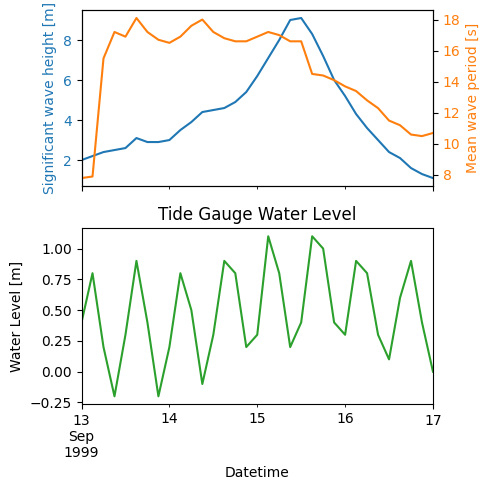

In [20]:
# Set up a figure with 2 rows and 1 column of subplots
fig, axs = plt.subplots(2, 1, figsize=(5, 5), sharex=True)
waves_tides = waves_tides.set_index('time')

# === Top panel: Waves ===
ax1 = axs[0]  # primary axis
ax2 = ax1.twinx()  # secondary Y-axis

# Plot Hs on the primary Y-axis
waves_tides['Hs'].plot(ax=ax1, color='tab:blue')
ax1.set_ylabel('Significant wave height [m]', color='tab:blue')
ax1.tick_params(axis='y', labelcolor='tab:blue')

# Plot Tmean on the secondary Y-axis
waves_tides['Tmean'].plot(ax=ax2, color='tab:orange')
ax2.set_ylabel('Mean wave period [s]', color='tab:orange')
ax2.tick_params(axis='y', labelcolor='tab:orange')

# === Bottom panel: Tides ===
waves_tides['WaterLevel'].plot(ax=axs[1], color='tab:green')
axs[1].set_ylabel('Water Level [m]')
axs[1].set_title('Tide Gauge Water Level')
axs[1].set_xlabel('Datetime')

# Improve layout
plt.tight_layout()
fig.savefig('waves_tides_plot.png', dpi=300)
plt.show()


## 🧮 Estimating Beach Slope from Field Data

In order to calculate wave runup, we need to know the **beach slope** — the steepness of the shoreface where waves run up onto the land.

### 🔍 What is beach slope?

The **beach slope** is usually calculated as:

\[
\text{slope} = \frac{\Delta h}{\Delta x}
\]

Where:
- \( \Delta h \) is the vertical difference in elevation (e.g., from the shoreline to the dune toe)
- \( \Delta x \) is the horizontal distance over which that elevation change occurs

In the field, this can be measured using:
- Beach profiles from GNSS, drones, or topographic surveys
- Cross-shore elevation transects

### 📐 Using measured slopes in our model

In this step:

1. We **enter several slope values** from real measurements (e.g., 0.04 means a 4% slope).
2. We assume the slopes follow a **normal distribution** and generate a random sample of slopes, one for each wave/tide measurement.
3. This simulates the **natural variability** of beach shape across the dataset.

These randomized slopes are stored in the dataframe and will be used in the runup calculations.

Enter measured beach slope values separated by commas (e.g., 0.04,0.05,0.045): 0.01,0.04,0.05,0.1


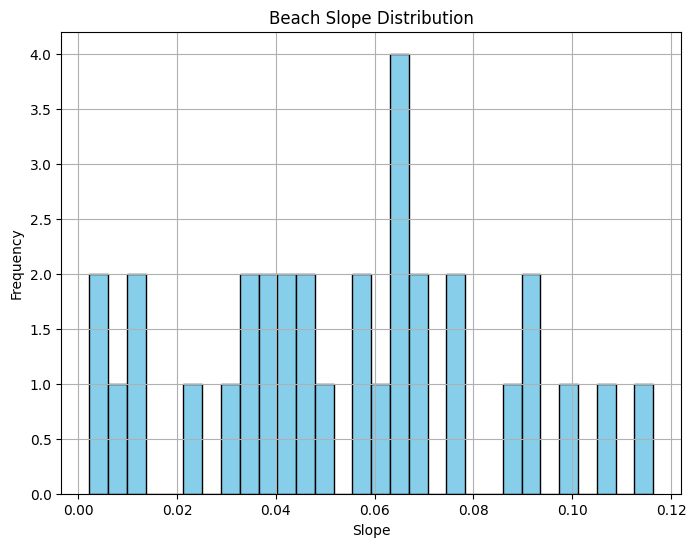

In [23]:
# Step 1: Ask the user to input slope values
# (for teaching, you might provide example values directly in code)
user_slopes = input("Enter measured beach slope values separated by commas (e.g., 0.04,0.05,0.045): ")

# Convert the input string to a list of floats
slope_values = [float(val.strip()) for val in user_slopes.split(',')]

# Step 2: Define the random slope generator
def generate_random_slopes(slope_list, length):
    """
    Generate a vector of random slopes from the distribution of measured slopes,
    ensuring no negative values.

    Args:
        slope_list (list): Measured slope values (floats)
        length (int): Length of output vector

    Returns:
        np.array: Array of slopes
    """
    mean_slope = np.mean(slope_list)
    std_slope = np.std(slope_list)

    # Generate slopes until all are positive
    while True:
        slopes = np.random.normal(loc=mean_slope, scale=std_slope, size=length)
        if np.all(slopes >= 0):  # Check if all values are non-negative
            break

    return slopes

def plot_slope_distribution(slopes, title="Beach Slope Distribution"):
    """
    Plots a histogram of the generated beach slopes.

    Args:
        slopes (np.array): Array of slope values.
        title (str, optional): Title of the plot. Defaults to "Beach Slope Distribution".
    """
    plt.figure(figsize=(8, 6))  # Adjust figure size as needed
    plt.hist(slopes, bins=30, color='skyblue', edgecolor='black')
    plt.title(title)
    plt.xlabel("Slope")
    plt.ylabel("Frequency")
    plt.grid(True)
    plt.show()


# Step 3: Generate the slope series for the merged dataframe
slope_series = generate_random_slopes(slope_values, len(waves_tides))

slope_series = generate_random_slopes(slope_values, len(waves_tides))
plot_slope_distribution(slope_series)

# Add it to the dataframe
waves_tides['slope'] = slope_series


## 🌊 Calculating Wave Runup Using Empirical Models

### 🔍 What is wave runup?

**Wave runup** is the maximum vertical extent that waves reach as they rush up the beach.  
It is influenced by factors like:
- **Wave height and period**
- **Beach slope**
- **Tide level**

Runup is important in coastal studies because it helps estimate the risk of **coastal flooding** and **erosion**, especially when combined with **sea-level rise**.

<div style="text-align: center">
    <img src="https://media.springernature.com/full/springer-static/image/art%3A10.1038%2Fs41598-017-01362-7/MediaObjects/41598_2017_1362_Fig1_HTML.jpg?as=webp" width="600">
    <br>
    <small><b>Figure:</b> Wave runup components. Source: Vitousek et al. (2017), <i>Scientific Reports</i>.  
    <a href="https://doi.org/10.1038/s41598-017-01362-7" target="_blank">https://doi.org/10.1038/s41598-017-01362-7</a></small>
</div>

---

### 🧠 What are we doing in this step?

We use multiple published empirical models to estimate the **2% exceedance runup level (`R2`)**, which represents the typical maximum runup height during energetic conditions.

Each model uses:
- **Hs**: Significant wave height
- **Tp (or Tmean)**: Wave period
- **β**: Beach slope
- **Tide level**: Added to runup to get total water elevation at the shoreline

We apply the following models:
- Stockdon et al. (2006)
- Vousdoukas et al. (2012)
- Holman (1986)
- Nielsen (2009)
- Ruggiero et al. (2001)
- Atkinson et al. (2017)
- Senechal et al. (2011)
- Passarella et al. (2018)

The results are stored in a new dataframe and exported for further analysis.

---

### 📦 About `py-wave-runup`

These models are implemented in the open-source Python package [`py-wave-runup`](https://py-wave-runup.readthedocs.io/en/latest/?badge=latest), developed by Chris Leaman.

> 📚 **Documentation**:  
> https://py-wave-runup.readthedocs.io/en/latest/?badge=latest

Please acknowledge the creators if you use this tool in a project or publication.

In [24]:
# === Step 1: Extract input variables from the merged dataframe ===

# VHM0: Significant wave height (Hs) time series
VHM0 = waves_tides['Hs'].tolist()

# VTPK: Mean wave period (Tmean) time series
VTPK = waves_tides['Tmean'].tolist()

# tide: Water level time series from the tide gauge
tide = waves_tides['WaterLevel'].tolist()

# slope: Beach slope values (randomly sampled earlier)
slope = waves_tides['slope'].tolist()


# === Step 2: Runup calculations using multiple empirical models ===

# Each model returns the 2% exceedance runup (R2)
# We then add the tide level to estimate the total water level at the shoreline
runup = {
    'Stockdon et al. (2006)': (models.Stockdon2006(Hs=VHM0, Tp=VTPK, beta=slope)).R2 + tide,
    'Vousdoukas et al. (2012)': (models.Vousdoukas2012(Hs=VHM0, Tp=VTPK, beta=slope)).R2 + tide,
    'Holman (1986)': (models.Holman1986(Hs=VHM0, Tp=VTPK, beta=slope)).R2 + tide,
    'Nielsen (2009)': (models.Nielsen2009(Hs=VHM0, Tp=VTPK, beta=slope)).R2 + tide,
    'Ruggiero et al. (2001)': (models.Ruggiero2001(Hs=VHM0, Tp=VTPK, beta=slope)).R2 + tide,
    'Atkinson et al. (2017)': (models.Atkinson2017(Hs=VHM0, Tp=VTPK, beta=slope)).R2 + tide,
    'Senechal et al. (2011)': (models.Senechal2011(Hs=VHM0, Tp=VTPK, beta=slope)).R2 + tide,
    'Passarella et al. (2018)': (models.Passarella2018(Hs=VHM0, Tp=VTPK, beta=slope)).swash + tide
}


# === Step 3: Convert results into a DataFrame ===

# Store the runup results from each model in a new dataframe
R2 = pd.DataFrame(runup)
waves_tides = waves_tides.reset_index()

# Merge the runup results with the original wave/tide data for reference
R2 = pd.merge(R2, waves_tides, left_index=True, right_index=True)

# Define the list of runup model columns (for later use in plots, stats, etc.)
columns = [
    'Stockdon et al. (2006)',
    'Vousdoukas et al. (2012)',
    'Holman (1986)',
    'Nielsen (2009)',
    'Ruggiero et al. (2001)',
    'Atkinson et al. (2017)',
    'Senechal et al. (2011)',
    'Passarella et al. (2018)'
]


# === Step 4: Export results to CSV ===

# Define output file name
output_path = 'runup_results.csv'

# Save the dataframe to a CSV file for future use
R2.to_csv(output_path, index=False)

## 📊 Runup Histograms by Model

To better understand how different empirical models behave, we visualize the **distribution of runup values** using histograms.

### What’s in this figure?

- Each of the **first 8 subplots** (top left to bottom middle) shows the distribution of runup heights calculated by a specific model.
- The **bottom-right subplot** overlays all models together so we can visually compare how their predictions differ.

📌 **Histograms** show how frequently different runup heights occur. This helps us:
- See whether some models predict consistently higher or lower runup values.
- Identify if the results are tightly clustered or spread over a wider range.

### Why is this useful?

Different models are based on different datasets and assumptions.  
By comparing them visually, we can better understand their behavior and identify which models might be more conservative or more extreme in their predictions.

The figure is saved automatically as a PNG so you can reuse it in reports or slides.

<ipython-input-25-a9e04bf66c82>:20: UserWarning: No artists with labels found to put in legend.  Note that artists whose label start with an underscore are ignored when legend() is called with no argument.
  axs[8].legend(fontsize='small')


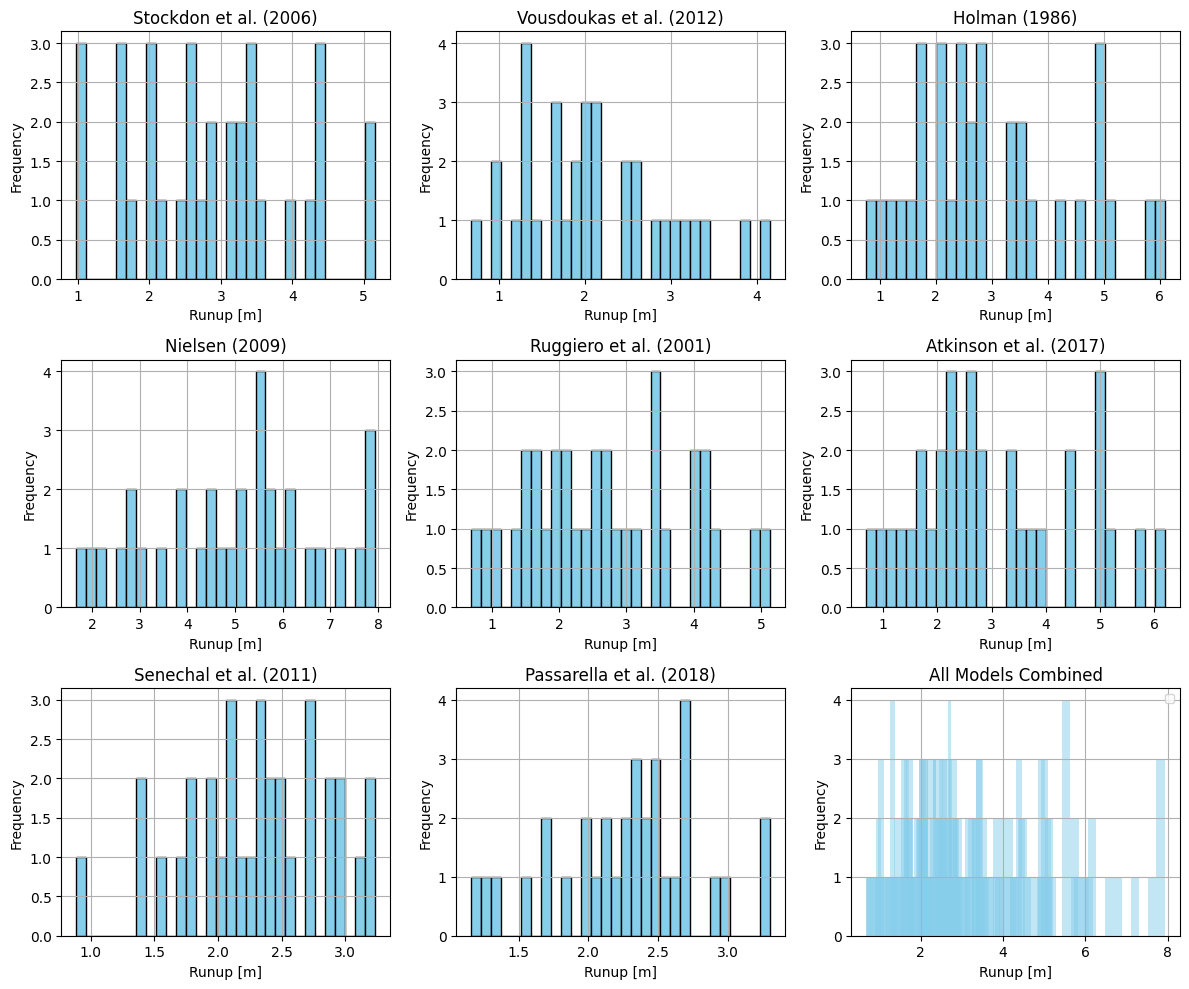

In [25]:
# Set up plot grid
fig, axs = plt.subplots(3, 3, figsize=(12, 10))
axs = axs.flatten()  # make indexing easier

# Plot individual histograms
for i, col in enumerate(columns):
    axs[i].hist(R2[col], bins=30, color='skyblue', edgecolor='black')
    axs[i].set_title(col)
    axs[i].set_xlabel('Runup [m]')
    axs[i].set_ylabel('Frequency')
    axs[i].grid(True)

# Plot all models together in the 9th subplot
for col in columns:
    axs[8].hist(R2[col], bins=30, alpha=0.5,color='skyblue')

axs[8].set_title('All Models Combined')
axs[8].set_xlabel('Runup [m]')
axs[8].set_ylabel('Frequency')
axs[8].legend(fontsize='small')
axs[8].grid(True)

# Remove axis from any unused subplot (not needed here, but just in case)
if len(axs) > 9:
    for ax in axs[9:]:
        ax.axis('off')

# Adjust layout
plt.tight_layout()
fig.savefig('waves_tides_plot.png', dpi=300)
plt.show()

## 🌍 Selecting an IPCC AR6 Sea-Level Rise Scenario

In this step, we load **sea-level rise projections** from the IPCC AR6 dataset, which provides estimates under different greenhouse gas emission scenarios (called **"SSPs"**).

These projections include:
- Multiple **scenarios** (e.g., `ssp119`, `ssp245`, `ssp585`) based on different levels of future emissions
- Different **years** (from 2020 to 2150)
- Several **confidence levels** (called **quantiles**, e.g., 5th, 50th, and 95th percentiles)

We'll use these projections later to simulate how **wave runup changes under future sea-level conditions**.

---

### 📥 How to get the sea-level rise Excel file

To obtain the projection data for your location:

1. Visit the NASA IPCC Sea-Level Projection Tool:  
   👉 [https://sealevel.nasa.gov/ipcc-ar6-sea-level-projection-tool](https://sealevel.nasa.gov/ipcc-ar6-sea-level-projection-tool)

2. On the map, **click on a tide gauge station** near your area of interest.

3. A new page will open with detailed projections. Scroll down and click:  
   **`GET DATA` → `Download all data for this location`**

4. This will download a `.xlsx` file.  
   Rename it if needed and place it in the **same folder** as this notebook (your working directory).

Once this file is loaded, we’ll be able to explore projections for different scenarios and time periods.

In [40]:
# Load the Excel file (sheet 'Total')
ipcc_path = os.path.join(working_dir, 'ipcc_ar6_sea_level_projection_psmsl_id_270.xlsx')
ipcc_df = pd.read_excel(ipcc_path, sheet_name='Total')

# Display unique scenario options
scenarios = ipcc_df['scenario'].unique()
years = [str(float(col)) for col in ipcc_df.columns if str(col).isdigit()]
quantiles = ipcc_df['quantile'].unique()

print("Available scenarios:", scenarios)
print("Available years:", years)
print("Available quantiles:", quantiles)

Available scenarios: ['ssp119' 'ssp126' 'ssp245' 'ssp370' 'ssp585']
Available years: ['2020.0', '2030.0', '2040.0', '2050.0', '2060.0', '2070.0', '2080.0', '2090.0', '2100.0', '2110.0', '2120.0', '2130.0', '2140.0', '2150.0']
Available quantiles: [ 5 17 50 83 95]


## 🔽 Selecting a Sea-Level Rise Scenario and Year (Interactive)

Now that we’ve loaded the IPCC sea-level rise projections, we can explore what the future might look like.

This interactive block lets you choose:
- A **climate scenario** (SSP):  
  For example, `ssp119` represents a very low-emissions future, while `ssp585` is a high-emissions scenario.
- A **future year**:  
  From 2020 to 2150, based on IPCC projections.

🧮 We automatically select the **50th percentile (median)** sea-level rise value for the combination you choose.  
This is a "most likely" estimate — halfway between the best- and worst-case projections.

### What happens after selection?

When you click **Get Projection**:
- The notebook will find the corresponding median sea-level rise value (in meters).
- This value will be displayed and used later to simulate how future sea-level rise could affect wave runup.

> 💡 Try comparing different scenarios to see how much the sea level might change depending on global emissions!

In [41]:
ipcc_df = pd.read_excel(ipcc_path, sheet_name='Total')
years = [str(col) for col in ipcc_df.columns if str(col).isdigit()]

# Filter to just the 50th percentile rows
ipcc_median = ipcc_df[ipcc_df['quantile'] == 50]

# Define dropdowns
scenario_dropdown = widgets.Dropdown(options=ipcc_median['scenario'].unique(), description='Scenario:')
year_dropdown = widgets.Dropdown(options=years, description='Year:')

# Display
display(scenario_dropdown, year_dropdown)

def get_median_slr(scenario, year):
    year = int(year)  # convert from string to int
    row = ipcc_median[ipcc_median['scenario'] == scenario]
    if year not in row.columns:
        raise ValueError(f"Year {year} not found in projection data.")
    return float(row[year].values[0])

# Button
confirm_button = widgets.Button(description="Get Projection")
output = widgets.Output()

# Callback
def on_button_clicked(b):
    with output:
        output.clear_output()
        slr = get_median_slr(scenario_dropdown.value, year_dropdown.value)
        print(f"📈 Median (50th percentile) SLR for {scenario_dropdown.value} in {year_dropdown.value}: {slr:.3f} meters")

confirm_button.on_click(on_button_clicked)
display(confirm_button, output)

Dropdown(description='Scenario:', options=('ssp119', 'ssp126', 'ssp245', 'ssp370', 'ssp585'), value='ssp119')

Dropdown(description='Year:', options=('2020', '2030', '2040', '2050', '2060', '2070', '2080', '2090', '2100',…

Button(description='Get Projection', style=ButtonStyle())

Output()

## 🌊 Adjusting Runup Values for Future Sea-Level Rise

Once we’ve selected a climate scenario and year, we look at the **projected sea-level rise (SLR)** for that case — not just for the median (50th percentile), but across all available **quantiles** (5th, 17th, 50th, 83rd, 95th).

This allows us to simulate a range of possible futures — from optimistic to more extreme outcomes.

### What does this code do?

1. It filters the IPCC data to keep only the projections for the **selected scenario** and the tide gauge location we’re using.
2. It loops through each quantile (e.g., 5, 50, 95):
   - Extracts the projected SLR for the selected **year**.
   - Creates a **copy of the original runup data**.
   - Adds the SLR value to each model’s runup estimate.
   - Saves the result in a dictionary called `adjusted_runup`.

Each version of the dataset shows how runup values would shift under a specific sea-level rise condition, allowing us to:
- Compare scenarios side by side
- Visualize how risk increases with higher projections
- Prepare for a range of future outcomes

> 🧠 This step is essential in **climate impact modeling**, where we apply realistic projections to physical processes to explore how our coastlines might change.

In [48]:
# Ensure year is an integer (matches Excel column type)
year_int = int(year_dropdown.value)
scenario = scenario_dropdown.value

# Get all quantiles for selected scenario
quantile_rows = ipcc_df[(ipcc_df['scenario'] == scenario))]

# Dictionary to store SLR-adjusted runup dataframes
adjusted_runup = {}

# Loop over each quantile row
for _, row in quantile_rows.iterrows():
    q = int(row['quantile'])  # e.g., 5, 50, 95
    slr = float(row[float(year_int)]) # Changed here

    # Copy original R2 and add SLR to each runup model column
    R2_slr = R2.copy()
    for col in columns:
        R2_slr[col] += slr

    # Optionally add a column showing the applied SLR
    R2_slr['SLR_applied'] = slr
    R2_slr['Quantile'] = q

    # Store in dictionary
    adjusted_runup[q] = R2_slr

SyntaxError: closing parenthesis ')' does not match opening parenthesis '[' (<ipython-input-48-698d6e597dce>, line 6)

## 📈 Comparing Present and Future Runup Distributions

To understand how **sea-level rise (SLR)** might affect coastal runup, we compare the **distribution of runup values** from today and from future climate scenarios.

Instead of using histograms, we use **Kernel Density Estimation (KDE)** — a smooth curve that shows where runup values are most concentrated.

---

### 🟧 Top panel: Present-day runup

- Shows the KDE curve for runup values **calculated from all 8 models** using current sea levels.
- The **black dashed line** marks the mean runup.

---

### 🔴 Bottom panel: Future runup under SLR

- Each curve represents a different **quantile** of the sea-level rise projections for the selected scenario and year.
- The colors move from blue (low projections) to red (high projections).
- **Vertical dashed lines** mark the **median runup** for each case.
- As SLR increases, the KDE curves **shift right**, indicating higher runup heights and greater coastal flood risk.

---

📊 This visualization helps us see not only how runup changes in the future, but also how **uncertain** those projections are — giving us a range of possible outcomes rather than a single number.

🧠 This is critical for coastal planning, where engineers and decision-makers need to consider both likely and extreme scenarios.

<ipython-input-43-199d9449a862>:22: MatplotlibDeprecationWarning: The get_cmap function was deprecated in Matplotlib 3.7 and will be removed in 3.11. Use ``matplotlib.colormaps[name]`` or ``matplotlib.colormaps.get_cmap()`` or ``pyplot.get_cmap()`` instead.
  cmap = get_cmap('coolwarm')
<ipython-input-43-199d9449a862>:51: UserWarning: No artists with labels found to put in legend.  Note that artists whose label start with an underscore are ignored when legend() is called with no argument.
  axs[1].legend(title='SLR Quantiles')


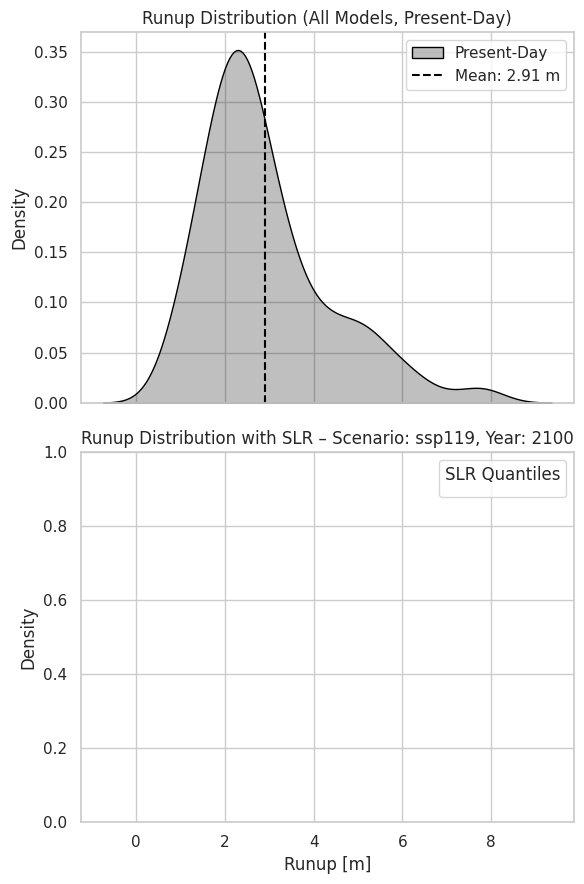

In [43]:
# Use a white grid style
sns.set(style="whitegrid")

# --- Prepare data ---

# Present-day combined runup data
combined_runup_no_slr = pd.concat([R2[col] for col in columns])
median_no_slr = np.mean(combined_runup_no_slr)

# Future SLR KDE data and medians
slr_kde_data = {}
slr_medians = {}

for q, df in adjusted_runup.items():
    combined = pd.concat([df[col] for col in columns])
    slr_kde_data[q] = combined
    slr_medians[q] = np.median(combined)

# Sorted quantiles for consistent coloring
sorted_quantiles = sorted(slr_kde_data.keys())
norm_positions = np.linspace(0, 1, len(sorted_quantiles))
cmap = get_cmap('coolwarm')
colors = [cmap(p) for p in norm_positions]

# --- Plotting ---

fig, axs = plt.subplots(2, 1, figsize=(6, 9), sharex=True)

# --- Top panel: Present-day KDE ---
sns.kdeplot(combined_runup_no_slr, ax=axs[0], color='black', fill=True, label='Present-Day')
axs[0].axvline(median_no_slr, color='black', linestyle='--', label=f'Mean: {median_no_slr:.2f} m')
axs[0].set_title('Runup Distribution (All Models, Present-Day)')
axs[0].set_ylabel('Density')
axs[0].legend()
axs[0].grid(True)

# --- Bottom panel: SLR KDEs ---
for i, q in enumerate(sorted_quantiles):
    data = slr_kde_data[q]
    median = slr_medians[q]
    color = colors[i]

    sns.kdeplot(data, ax=axs[1], fill=True, label=f'Quantile {q}', color=color, alpha=0.3)
    axs[1].axvline(median, linestyle='--', color=color, linewidth=1)
    axs[1].text(median, axs[1].get_ylim()[1]*0.9, f'{median:.2f}',
                ha='center', va='center', fontsize=8, rotation=90, color=color)

axs[1].set_title(f'Runup Distribution with SLR – Scenario: {scenario}, Year: {year_int}')
axs[1].set_xlabel('Runup [m]')
axs[1].set_ylabel('Density')
axs[1].legend(title='SLR Quantiles')
axs[1].grid(True)

plt.tight_layout()
plt.savefig(os.path.join(working_dir, f'runup_histograms_{scenario}_{year_int}.png'), dpi=300)
plt.show()

In [47]:
print(f"Rows for scenario '{scenario}' and psmsl_id == 59: {len(quantile_rows)}")

Rows for scenario 'ssp119' and psmsl_id == 59: 0


## 💾 Exporting Runup Data for Visualization and Analysis

To make our results more accessible and reusable, we export the **runup values used in the KDE plot** to a CSV file.

### 📂 What’s in the exported file?

The file includes:
- A column for the **present-day runup values** (combined from all 8 models)
- One column for each **sea-level rise quantile** (e.g., Quantile 5, 50, 95), adjusted according to the selected scenario and year
- Each row represents one runup estimate from one of the models

This format allows you to:
- Recreate the KDE plots or histograms in other software (like Excel, R, or MATLAB)
- Calculate your own statistics (mean, median, percentiles)
- Compare future runup projections under different climate assumptions

The exported CSV is saved in your working directory.

> 💡 This step is especially useful if you want to document your results, create figures for a report, or share your analysis with others.

In [ ]:
# Create a new DataFrame to store all combined values
export_kde_data = pd.DataFrame()

# Add present-day combined runup values
export_kde_data['Present_Day'] = pd.concat([R2[col] for col in columns]).reset_index(drop=True)

# Add each SLR-adjusted set (combined from all models) as a separate column
for q in sorted_quantiles:
    combined_slr = pd.concat([adjusted_runup[q][col] for col in columns]).reset_index(drop=True)
    export_kde_data[f'Quantile_{q}'] = combined_slr

# Export to CSV
kde_export_path = os.path.join(working_dir, f'runup_kde_data_{scenario}_{year_int}.csv')
export_kde_data.to_csv(kde_export_path, index=False)

print(f"✅ KDE data exported to: {kde_export_path}")

---

## 📝 Acknowledgments

This script was developed by **Alessio Rovere** at **Ca' Foscari University of Venice**, with the support of **ChatGPT by OpenAI** for code structuring, optimization, and documentation refinement.

This work is part of the **WARMCOASTS** project, funded by the **European Research Council (ERC)** under the European Union’s Horizon 2020 research and innovation programme (grant agreement n. **802414**).

⚠️ **Disclaimer:**  
The code is provided *as is*, without any warranties or guarantees of correctness. Users are responsible for verifying results and adapting the scripts to their specific needs. Neither the authors nor the European Union can be held responsible for any use that may be made of the information or code contained herein.